
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br> <br>
<font color=2565AE size=5>
    CE Department <br>
    Fall 2024 - Prof. Sharifi Zarchi<br>
<font color=3C99D size=5>
    HW4 Practical <br>
    Image Colorization<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Shabani


This assignment is structured to introduce students to practical applications of generative models in computer vision.
It targets two challenging areas: colorization and segmentation, using architectures that are complex but very applicable in industry settings.
## Machine Learning Assignment #4: Practical Applications in Image Processing

## Learning Objectives:
By the end of this assignment, students will be able to:
1. Understand and implement Variational Autoencoders for image colorization.
2. Apply the U-Net architecture for image segmentation.
3. Preprocess image datasets, including augmentation techniques.
4. Analyze the performance of machine learning models using relevant metrics.
5. Explore the relationship between latent space and output quality in generative models.


# Image Colorization using VAE
In this section of the assignment, students will explore the fascinating field of image colorization using Variational Autoencoders (VAEs), a type of generative model in deep learning. The task involves transforming grayscale images into colored ones, leveraging the encoder-decoder architecture of VAEs, which are adept at learning complex data distributions. Students will implement and fine-tune an autoencoder network, utilizing components like perceptual loss and feature extraction from pre-trained models, to improve colorization output. By doing so, they will gain a deeper understanding of generative models and their practical applications in computer vision tasks. This exercise offers a hands-on opportunity to blend theoretical knowledge with practical coding skills, characterizing the creative potential of AI in image processing.

Dataset: https://drive.google.com/drive/folders/1KeJbfUykGnPlz0q08_b1IjtW8OxkPdQ9?usp=sharing

## Importing Libraries

In [2]:
!pip install pytorch_lightning
!pip install seaborn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Metric
import torchvision
from PIL import Image
import math

print(plt.style.available)
plt.style.use("seaborn-v0_8")
device = "cuda" if torch.cuda.is_available() else "cpu"

np.__version__, device

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


('1.26.4', 'cuda')

## Loading the Data

In [4]:
import os
import pandas as pd
from tqdm import tqdm


def load_data(PATH):
    # TODO: Initialize lists to store filenames and their corresponding outcomes
    filenames = []
    outcomes = []

    for class_name in tqdm(os.listdir(PATH)):
        class_folder = os.path.join(PATH, class_name)
        print(class_folder)
        for filename in os.listdir(class_folder):
            filenames.append(os.path.join(class_folder, filename))
            outcomes.append(class_name)

    # TODO: Create a DataFrame from the filenames and outcomesa
    df = pd.DataFrame({"filename": filenames, "outcome": outcomes})

    # TODO: Return the shuffled DataFrame
    return df.sample(frac=1).reset_index(drop=True)


# TODO: Load the training, validation, and test data using the load_data function
BASE_PATH = "../input/ml-p2-cnn/data"
train_path = os.path.join(BASE_PATH, "train")
train_df = load_data(train_path)

val_path = os.path.join(BASE_PATH, "valid")
val_df = load_data(val_path)

test_path = os.path.join(BASE_PATH, "test")
test_df = load_data(test_path)


# TODO: Check the shape of the loaded DataFrames to verify correct data loading
print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")

100%|██████████| 20/20 [00:00<00:00, 156.57it/s]


../input/ml-p2-cnn/data/train/AMERICAN KESTREL
../input/ml-p2-cnn/data/train/AMERICAN GOLDFINCH
../input/ml-p2-cnn/data/train/AFRICAN PYGMY GOOSE
../input/ml-p2-cnn/data/train/ABYSSINIAN GROUND HORNBILL
../input/ml-p2-cnn/data/train/ALBERTS TOWHEE
../input/ml-p2-cnn/data/train/AFRICAN EMERALD CUCKOO
../input/ml-p2-cnn/data/train/ALBATROSS
../input/ml-p2-cnn/data/train/AMERICAN BITTERN
../input/ml-p2-cnn/data/train/AMERICAN COOT
../input/ml-p2-cnn/data/train/ABBOTTS BABBLER
../input/ml-p2-cnn/data/train/AFRICAN FIREFINCH
../input/ml-p2-cnn/data/train/ALEXANDRINE PARAKEET
../input/ml-p2-cnn/data/train/ALPINE CHOUGH
../input/ml-p2-cnn/data/train/AMERICAN FLAMINGO
../input/ml-p2-cnn/data/train/AMERICAN AVOCET
../input/ml-p2-cnn/data/train/ALTAMIRA YELLOWTHROAT
../input/ml-p2-cnn/data/train/AFRICAN PIED HORNBILL
../input/ml-p2-cnn/data/train/AFRICAN CROWNED CRANE
../input/ml-p2-cnn/data/train/AFRICAN OYSTER CATCHER
../input/ml-p2-cnn/data/train/ABBOTTS BOOBY


  0%|          | 0/20 [00:00<?, ?it/s]

../input/ml-p2-cnn/data/valid/AMERICAN KESTREL
../input/ml-p2-cnn/data/valid/AMERICAN GOLDFINCH
../input/ml-p2-cnn/data/valid/AFRICAN PYGMY GOOSE
../input/ml-p2-cnn/data/valid/ABYSSINIAN GROUND HORNBILL
../input/ml-p2-cnn/data/valid/ALBERTS TOWHEE
../input/ml-p2-cnn/data/valid/AFRICAN EMERALD CUCKOO
../input/ml-p2-cnn/data/valid/ALBATROSS
../input/ml-p2-cnn/data/valid/AMERICAN BITTERN
../input/ml-p2-cnn/data/valid/AMERICAN COOT
../input/ml-p2-cnn/data/valid/ABBOTTS BABBLER
../input/ml-p2-cnn/data/valid/AFRICAN FIREFINCH
../input/ml-p2-cnn/data/valid/ALEXANDRINE PARAKEET
../input/ml-p2-cnn/data/valid/ALPINE CHOUGH
../input/ml-p2-cnn/data/valid/AMERICAN FLAMINGO
../input/ml-p2-cnn/data/valid/AMERICAN AVOCET
../input/ml-p2-cnn/data/valid/ALTAMIRA YELLOWTHROAT
../input/ml-p2-cnn/data/valid/AFRICAN PIED HORNBILL


100%|██████████| 20/20 [00:00<00:00, 290.75it/s]


../input/ml-p2-cnn/data/valid/AFRICAN CROWNED CRANE
../input/ml-p2-cnn/data/valid/AFRICAN OYSTER CATCHER
../input/ml-p2-cnn/data/valid/ABBOTTS BOOBY


100%|██████████| 20/20 [00:00<00:00, 384.83it/s]

../input/ml-p2-cnn/data/test/AMERICAN KESTREL
../input/ml-p2-cnn/data/test/AMERICAN GOLDFINCH
../input/ml-p2-cnn/data/test/AFRICAN PYGMY GOOSE
../input/ml-p2-cnn/data/test/ABYSSINIAN GROUND HORNBILL
../input/ml-p2-cnn/data/test/ALBERTS TOWHEE
../input/ml-p2-cnn/data/test/AFRICAN EMERALD CUCKOO
../input/ml-p2-cnn/data/test/ALBATROSS
../input/ml-p2-cnn/data/test/AMERICAN BITTERN
../input/ml-p2-cnn/data/test/AMERICAN COOT
../input/ml-p2-cnn/data/test/ABBOTTS BABBLER
../input/ml-p2-cnn/data/test/AFRICAN FIREFINCH
../input/ml-p2-cnn/data/test/ALEXANDRINE PARAKEET
../input/ml-p2-cnn/data/test/ALPINE CHOUGH
../input/ml-p2-cnn/data/test/AMERICAN FLAMINGO
../input/ml-p2-cnn/data/test/AMERICAN AVOCET
../input/ml-p2-cnn/data/test/ALTAMIRA YELLOWTHROAT
../input/ml-p2-cnn/data/test/AFRICAN PIED HORNBILL
../input/ml-p2-cnn/data/test/AFRICAN CROWNED CRANE
../input/ml-p2-cnn/data/test/AFRICAN OYSTER CATCHER
../input/ml-p2-cnn/data/test/ABBOTTS BOOBY
Train data shape: (3208, 2)
Validation data shape: (

In [5]:
# TODO: Combine the training and test data into a single DataFrame along the vertical axis
combined_df = pd.concat([train_df, val_df, test_df], axis=0)
print(f"Combined shape: {combined_df.shape}")

Combined shape: (3408, 2)


In [6]:
# TODO: Explore the new DataFrame
combined_df.sample(n=5)

filename  \
1795  ../input/ml-p2-cnn/data/train/AMERICAN BITTERN...   
2793  ../input/ml-p2-cnn/data/train/ABYSSINIAN GROUN...   
1758  ../input/ml-p2-cnn/data/train/AFRICAN PIED HOR...   
520   ../input/ml-p2-cnn/data/train/AFRICAN OYSTER C...   
1470  ../input/ml-p2-cnn/data/train/AFRICAN CROWNED ...   

                         outcome  
1795            AMERICAN BITTERN  
2793  ABYSSINIAN GROUND HORNBILL  
1758       AFRICAN PIED HORNBILL  
520       AFRICAN OYSTER CATCHER  
1470       AFRICAN CROWNED CRANE

## Plot some of the images

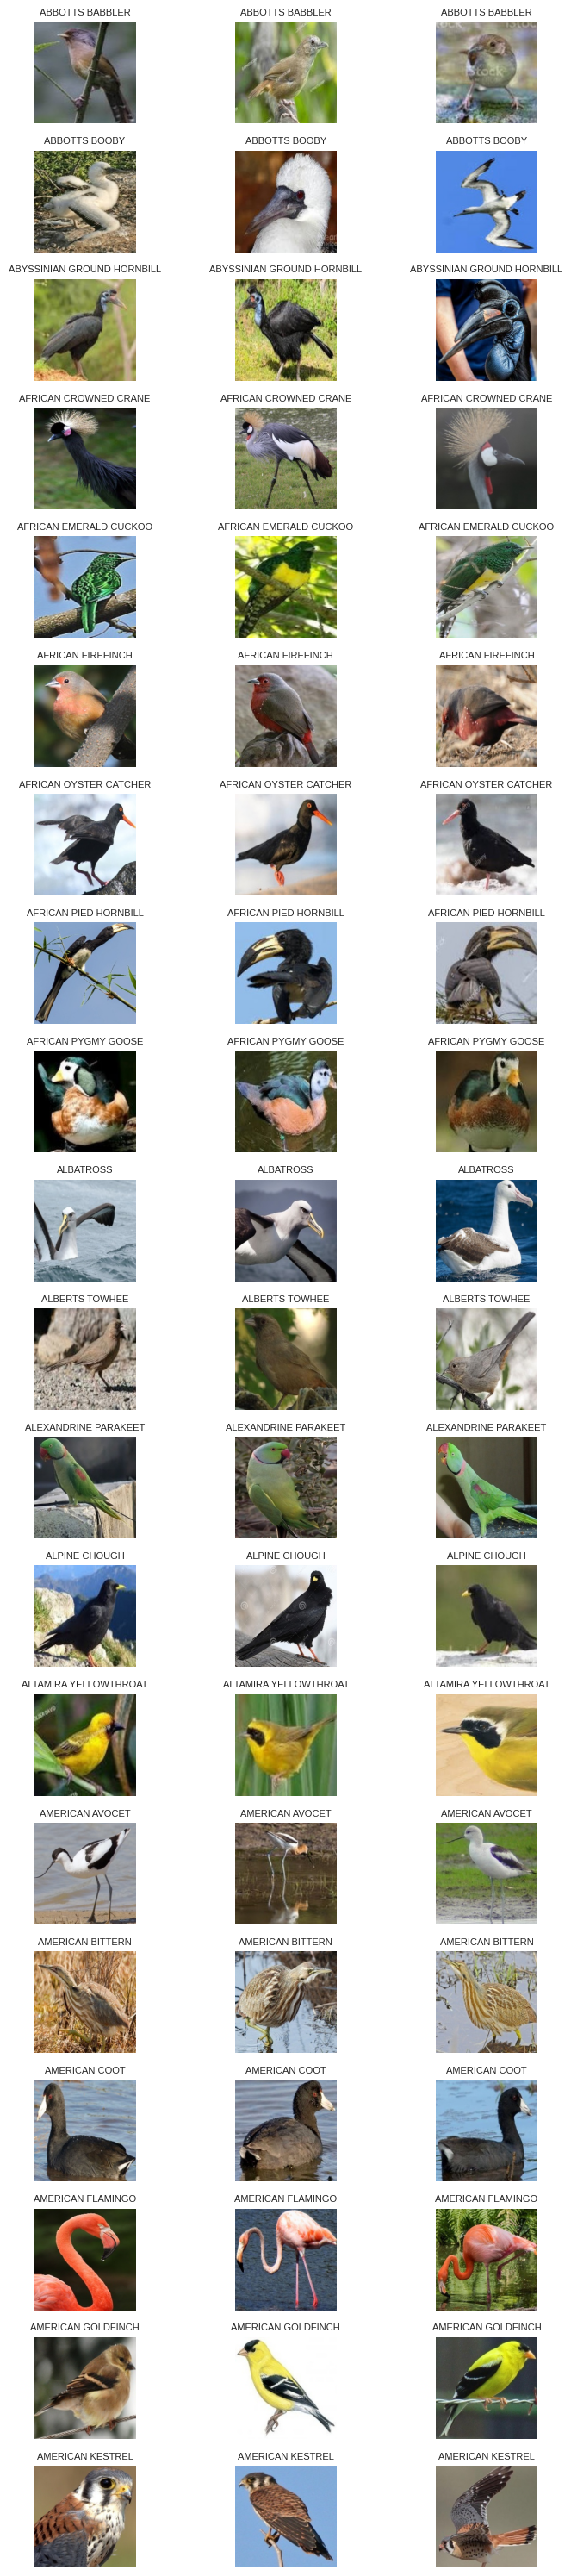

In [7]:
# TODO: Plot some of images
sampled_data = combined_df.groupby("outcome").apply(
    lambda x: x.sample(n=3, replace=True)
)

fig, axes = plt.subplots(20, 3, figsize=(8, 30))
axes = axes.flatten()

for i, (index, row) in enumerate(sampled_data.iterrows()):
    img = plt.imread(row["filename"])
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(row["outcome"], fontsize=8)

plt.tight_layout()
plt.show()


## Dataset Distribution
plot the distribution of the dataset, both training and validation set

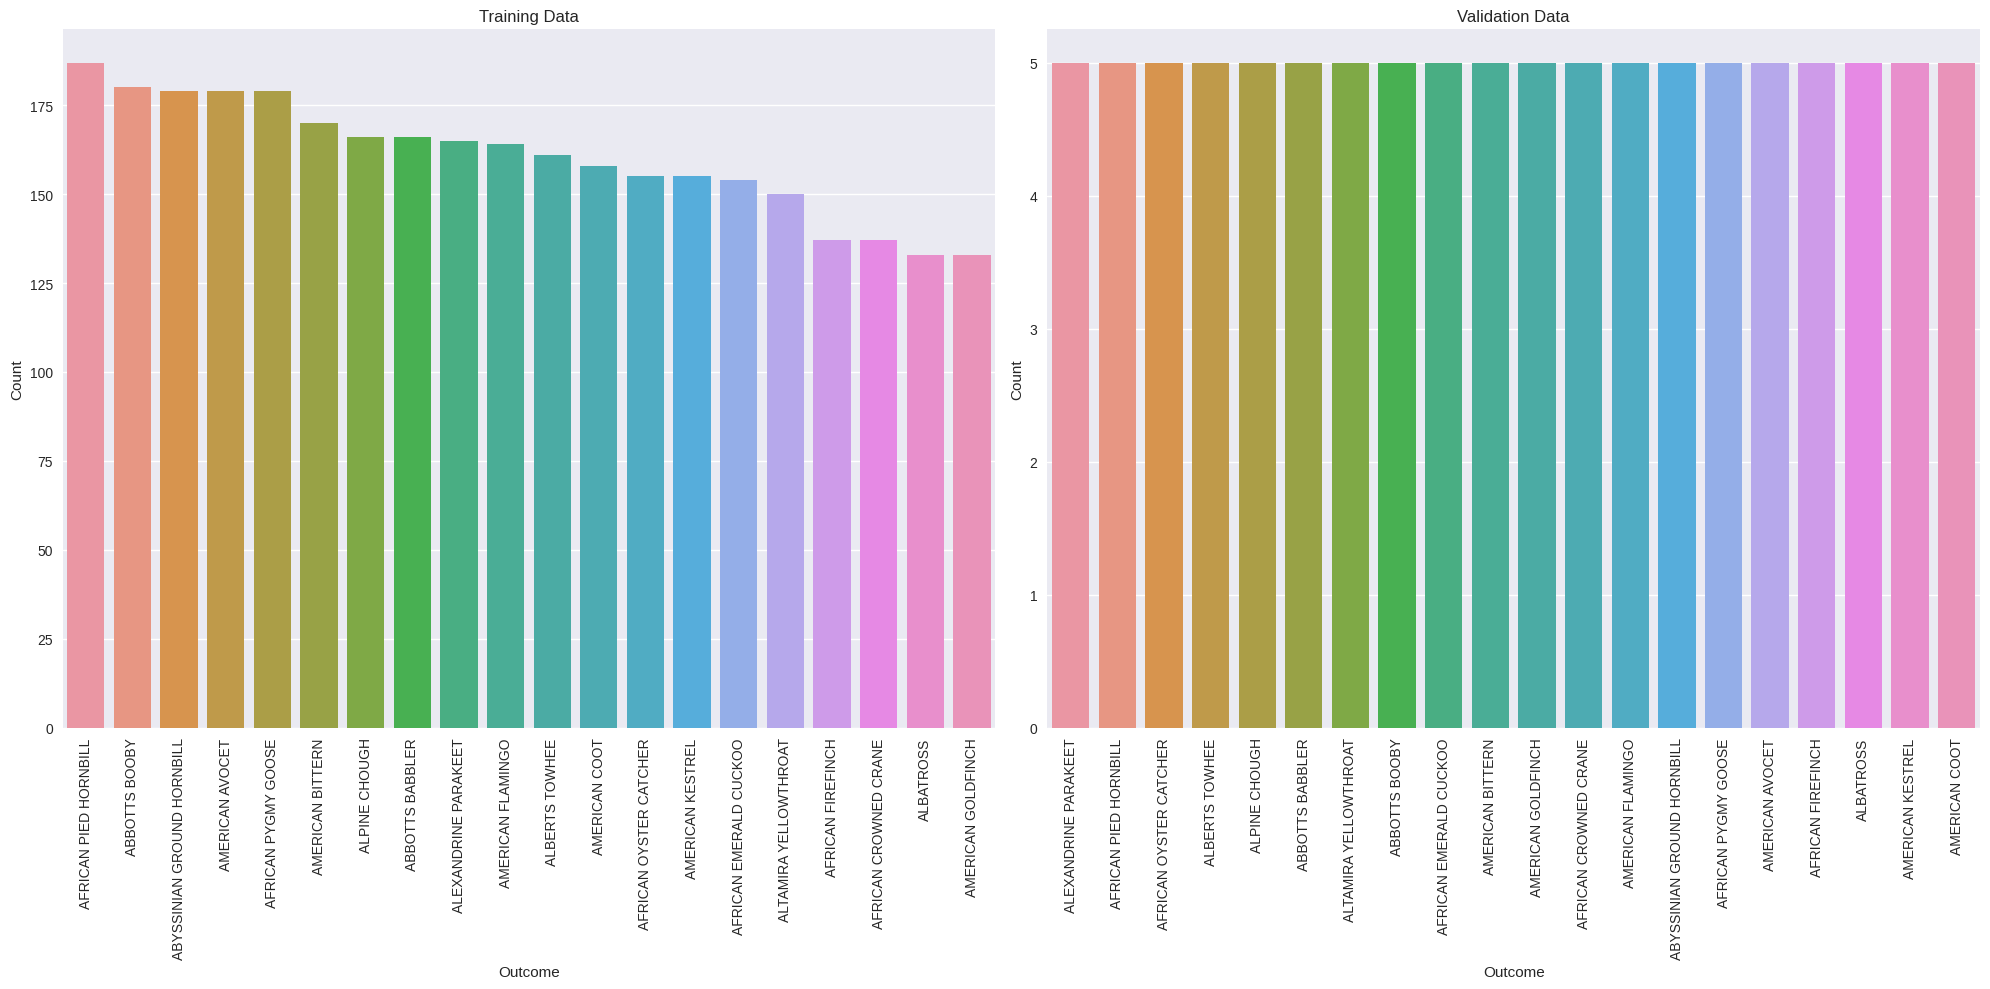

In [8]:
# TODO: Plot the distribution of classes
# If you want to combine plots into a single visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sea.countplot(
    ax=axes[0],
    data=train_df,
    x="outcome",
    order=train_df["outcome"].value_counts().index,
)
axes[0].set_title("Training Data")
axes[0].set_xlabel("Outcome")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=90)

sea.countplot(
    ax=axes[1], data=val_df, x="outcome", order=val_df["outcome"].value_counts().index
)
axes[1].set_title("Validation Data")
axes[1].set_xlabel("Outcome")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=90)


plt.tight_layout()
plt.show()

## Dataset Preparation
Now we are going to build the dataset by using `Dataset` and `DataLoader` classes within PyTorch. I recommend you to randomly crop the images to (160, 160) and then normalize them.

In [9]:
class BirdDataset:
    def __init__(self, df, transform=None):
        # TODO: Initialize the needed data
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # TODO: Load and transform an image
        # - Image should be converted to grayscale and then transformed
        img_path = self.df.loc[idx, "filename"]
        target_image = Image.open(img_path)
        input_image = target_image.convert("L")

        if self.transform:
            input_image = self.transform[0](input_image)
            target_image = self.transform[1](target_image)

        return input_image, target_image


# TODO: Apply preprocessings on the image dataset (increasing saturation, ...) by using transforms.ColorJitter for example.
input_mean = [0.5]
input_std = [0.5]
output_mean = [0.485, 0.456, 0.406]
output_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=input_mean, std=input_std)
    ]
)

val_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=input_mean, std=input_std)
    ]
)

target_transform = transforms.Compose(
    [transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=output_mean, std=output_std)]
)

train_dataset = BirdDataset(train_df, transform=(train_transform, target_transform))
val_dataset = BirdDataset(val_df, transform=(val_transform, target_transform))
test_dataset = BirdDataset(test_df, transform=(val_transform, target_transform))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

# TODO: Define transforms and datasets and data loaders

Images shape: torch.Size([32, 1, 224, 224])
Labels shape: torch.Size([32, 3, 224, 224])


**Why is data augmentation pivotal in training models for image tasks, and what techniques are beneficial for this particular assignment?**

## Model Architecture
The model has an encoder block for encoding the grayscale image into a lower representation followed by a decoder block to generate the colorized image.

In [10]:
import torch.nn as nn
import torch
import torch.optim as optim
from tqdm import tqdm
from torchvision.models import vgg16, VGG16_Weights
import torch.nn.functional as F

# The following classes define the various components of our VAE model.
# Each class includes a simple explanation of its role in the overall architecture.

# The VAE consists of an encoder to compress the input into a smaller latent representation,
# and a decoder to reconstruct the colorized output from the latent space.


# Hint for students: Initialize the perceptual loss with different feature layers based on the network architecture.
# - You have to use VGG pretrained model for this part
class PerceptualLoss(nn.Module):
    def __init__(self, feature_layers=None, use_half=False):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg16(weights=VGG16_Weights.DEFAULT).features
        for layer in self.vgg:
            if isinstance(layer, nn.ReLU):
                layer.inplace = False
            
        self.feature_layers = feature_layers or [3, 8, 15, 22]
        self.hooks = []
        self.use_half = use_half

        for layer_id in self.feature_layers:
            self.hooks.append(self.vgg[layer_id])
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        loss = 0.0
        for hook in self.hooks:
            x = hook(x).clone()
            y = hook(y).clone()
            loss += F.mse_loss(x, y)
        return loss


# Hint: Define the structure of the encoder by using convolutional layers with optional batch normalization.
class Encoder(nn.Module):
    def __init__(self, do_bn=False):
        super(Encoder, self).__init__()
        self.do_bn = do_bn
        self.blocks = nn.Sequential(
            self.inner_block(1, 32),
            self.inner_block(32, 64),
            self.inner_block(64, 128),
            self.inner_block(128, 256),
            self.inner_block(256, 512),
        )

    def inner_block(self, in_c, out_c, maxpool=2):
        # TODO: Implement a sequential block containing convolution, batch norm, ReLU, pooling, and dropout layers.
        layers = [
            nn.Conv2d(
                in_channels=in_c, out_channels=out_c, kernel_size=3, stride=1, padding=1
            ),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=maxpool),
            nn.Dropout(p=0.2)
        ]
        if self.do_bn:
            layers.insert(1, nn.BatchNorm2d(out_c))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.blocks(x)


# Hint: Define the decoder's symmetric structure to the encoder for upsampling and reconstructing the input.
class Decoder(nn.Module):
    def __init__(self, do_bn):
        # TODO: Use ConvTransposed2d
        super(Decoder, self).__init__()
        self.do_bn = do_bn
        self.blocks = nn.Sequential(
            self.inner_block(512, 256),
            self.inner_block(256, 128),
            self.inner_block(128, 64),
            self.inner_block(64, 32),
            self.inner_block(32, 3, out=True),
        )

    def inner_block(self, in_c, out_c, out=False):
        layers = [
            nn.ConvTranspose2d(
                in_channels=in_c, out_channels=out_c, kernel_size=4, stride=2, padding=1
            ),
            nn.ReLU(inplace=False),
        ]
        if self.do_bn:
            layers.insert(1, nn.BatchNorm2d(out_c))
        if out:
            layers.pop(1)
        return nn.Sequential(*layers)

    def forward(self, h):
        return self.blocks(h)


# Hint: Integrate the encoder, decoder, and loss components into the overall network class.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = Encoder(do_bn=True)
        self.decoder = Decoder(do_bn=True)
        self.perceptual_loss = PerceptualLoss()

    def forward(self, x):
        h = self.encoder(x)
        x_recon = self.decoder(h)
        return x_recon

    def compute_loss(self, pred, target):
        # TODO: Calculate the combined loss from multiple loss functions.
        loss = F.mse_loss(pred, target)
        perceptual_loss = self.perceptual_loss(pred, target)
        return loss + 0.1 * perceptual_loss

    def training_step(self, data, device):
        self.train()
        X, y = data
        X, y = X.to(device), y.to(device)
        y_pred = self.forward(X)
        loss = self.compute_loss(y_pred, y)
        return loss

    def validation_step(self, data, device):
        self.eval()
        X, y = data
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            return loss

    def train_model(self, train_loader, val_loader, optimizer, device, epochs=10):
        self.to(device)
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            train_loss = 0
            val_loss = 0
            for data in tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}"):
                optimizer.zero_grad()
                loss = self.training_step(data, device)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            for data in tqdm(val_loader, desc=f"Validation {epoch+1}/{epochs}"):
                loss = self.validation_step(data, device)
                val_loss += loss.item()
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            print(
                f"epoch: {epoch}/{epochs}, Train Loss: {np.round(train_losses[-1], 4)}, Val Loss: {np.round(val_losses[-1], 4)}"
            )
        return train_losses, val_losses

In [11]:
# TODO: print the model
print(Net())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 221MB/s] 


Net(
  (encoder): Encoder(
    (blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Dropout(p=0.2, inplace=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(

## Training Phase

In [12]:
# TODO: Train
# Students should implement the training loop. During training, monitor both training and validation metrics
# to ensure the model learns effectively without overfitting.
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses = model.train_model(train_loader, val_loader, optimizer, device=device, epochs=50)

Validation 1/50: 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]


epoch: 0/50, Train Loss: 1.3423, Val Loss: 1.2161


Validation 2/50: 100%|██████████| 4/4 [00:00<00:00,  9.19it/s]


epoch: 1/50, Train Loss: 1.2687, Val Loss: 1.1575


Validation 3/50: 100%|██████████| 4/4 [00:00<00:00,  9.08it/s]


epoch: 2/50, Train Loss: 1.2489, Val Loss: 1.1306


Validation 4/50: 100%|██████████| 4/4 [00:00<00:00,  9.15it/s]


epoch: 3/50, Train Loss: 1.2098, Val Loss: 1.1612


Validation 5/50: 100%|██████████| 4/4 [00:00<00:00,  9.39it/s]


epoch: 4/50, Train Loss: 1.1934, Val Loss: 1.2078


Validation 6/50: 100%|██████████| 4/4 [00:00<00:00,  9.69it/s]


epoch: 5/50, Train Loss: 1.1811, Val Loss: 1.2192


Validation 7/50: 100%|██████████| 4/4 [00:00<00:00,  9.86it/s]


epoch: 6/50, Train Loss: 1.1821, Val Loss: 1.1197


Validation 8/50: 100%|██████████| 4/4 [00:00<00:00,  9.33it/s]


epoch: 7/50, Train Loss: 1.1671, Val Loss: 1.1482


Validation 9/50: 100%|██████████| 4/4 [00:00<00:00, 10.07it/s]


epoch: 8/50, Train Loss: 1.1583, Val Loss: 1.1559


Validation 10/50: 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


epoch: 9/50, Train Loss: 1.1507, Val Loss: 1.0411


Validation 11/50: 100%|██████████| 4/4 [00:00<00:00,  9.68it/s]


epoch: 10/50, Train Loss: 1.1577, Val Loss: 1.0854


Validation 12/50: 100%|██████████| 4/4 [00:00<00:00, 10.00it/s]


epoch: 11/50, Train Loss: 1.1492, Val Loss: 1.1106


Validation 13/50: 100%|██████████| 4/4 [00:00<00:00,  9.54it/s]


epoch: 12/50, Train Loss: 1.1519, Val Loss: 1.1511


Validation 14/50: 100%|██████████| 4/4 [00:00<00:00,  9.67it/s]


epoch: 13/50, Train Loss: 1.1489, Val Loss: 1.2273


Validation 15/50: 100%|██████████| 4/4 [00:00<00:00, 10.38it/s]


epoch: 14/50, Train Loss: 1.1501, Val Loss: 1.0404


Validation 16/50: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


epoch: 15/50, Train Loss: 1.1469, Val Loss: 1.0861


Validation 17/50: 100%|██████████| 4/4 [00:00<00:00,  9.55it/s]


epoch: 16/50, Train Loss: 1.1406, Val Loss: 1.0585


Validation 18/50: 100%|██████████| 4/4 [00:00<00:00,  9.83it/s]


epoch: 17/50, Train Loss: 1.1441, Val Loss: 1.0949


Validation 19/50: 100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


epoch: 18/50, Train Loss: 1.1398, Val Loss: 1.0776


Validation 20/50: 100%|██████████| 4/4 [00:00<00:00,  9.60it/s]


epoch: 19/50, Train Loss: 1.146, Val Loss: 1.0951


Validation 21/50: 100%|██████████| 4/4 [00:00<00:00, 10.10it/s]


epoch: 20/50, Train Loss: 1.1395, Val Loss: 1.0435


Validation 22/50: 100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


epoch: 21/50, Train Loss: 1.1429, Val Loss: 1.0928


Validation 23/50: 100%|██████████| 4/4 [00:00<00:00, 10.12it/s]


epoch: 22/50, Train Loss: 1.1406, Val Loss: 1.0234


Validation 24/50: 100%|██████████| 4/4 [00:00<00:00, 10.59it/s]


epoch: 23/50, Train Loss: 1.1321, Val Loss: 1.0759


Validation 25/50: 100%|██████████| 4/4 [00:00<00:00, 10.26it/s]


epoch: 24/50, Train Loss: 1.1325, Val Loss: 1.0409


Validation 26/50: 100%|██████████| 4/4 [00:00<00:00,  8.37it/s]


epoch: 25/50, Train Loss: 1.1373, Val Loss: 1.02


Validation 27/50: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


epoch: 26/50, Train Loss: 1.1325, Val Loss: 1.0347


Validation 28/50: 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]


epoch: 27/50, Train Loss: 1.1371, Val Loss: 1.0068


Validation 29/50: 100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


epoch: 28/50, Train Loss: 1.1327, Val Loss: 1.0861


Validation 30/50: 100%|██████████| 4/4 [00:00<00:00,  8.05it/s]


epoch: 29/50, Train Loss: 1.1274, Val Loss: 1.0764


Validation 31/50: 100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


epoch: 30/50, Train Loss: 1.1309, Val Loss: 1.0491


Validation 32/50: 100%|██████████| 4/4 [00:00<00:00,  9.74it/s]


epoch: 31/50, Train Loss: 1.1273, Val Loss: 1.0741


Validation 33/50: 100%|██████████| 4/4 [00:00<00:00, 10.07it/s]


epoch: 32/50, Train Loss: 1.1288, Val Loss: 1.0072


Validation 34/50: 100%|██████████| 4/4 [00:00<00:00, 10.16it/s]


epoch: 33/50, Train Loss: 1.1248, Val Loss: 1.0882


Validation 35/50: 100%|██████████| 4/4 [00:00<00:00,  9.45it/s]


epoch: 34/50, Train Loss: 1.1271, Val Loss: 1.0171


Validation 36/50: 100%|██████████| 4/4 [00:00<00:00, 10.01it/s]


epoch: 35/50, Train Loss: 1.1182, Val Loss: 1.081


Validation 37/50: 100%|██████████| 4/4 [00:00<00:00,  9.67it/s]


epoch: 36/50, Train Loss: 1.1285, Val Loss: 1.0731


Validation 38/50: 100%|██████████| 4/4 [00:00<00:00,  8.42it/s]


epoch: 37/50, Train Loss: 1.1272, Val Loss: 1.0417


Validation 39/50: 100%|██████████| 4/4 [00:00<00:00,  9.57it/s]


epoch: 38/50, Train Loss: 1.1234, Val Loss: 1.1086


Validation 40/50: 100%|██████████| 4/4 [00:00<00:00,  8.91it/s]


epoch: 39/50, Train Loss: 1.1253, Val Loss: 1.062


Validation 41/50: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


epoch: 40/50, Train Loss: 1.1269, Val Loss: 1.0354


Validation 42/50: 100%|██████████| 4/4 [00:00<00:00,  9.83it/s]


epoch: 41/50, Train Loss: 1.1186, Val Loss: 1.0791


Validation 43/50: 100%|██████████| 4/4 [00:00<00:00,  9.54it/s]


epoch: 42/50, Train Loss: 1.1209, Val Loss: 1.0236


Validation 44/50: 100%|██████████| 4/4 [00:00<00:00,  8.88it/s]


epoch: 43/50, Train Loss: 1.119, Val Loss: 1.0771


Validation 45/50: 100%|██████████| 4/4 [00:00<00:00,  9.83it/s]


epoch: 44/50, Train Loss: 1.1168, Val Loss: 1.0355


Validation 46/50: 100%|██████████| 4/4 [00:00<00:00,  8.84it/s]


epoch: 45/50, Train Loss: 1.1209, Val Loss: 1.0403


Validation 47/50: 100%|██████████| 4/4 [00:00<00:00,  9.41it/s]


epoch: 46/50, Train Loss: 1.1219, Val Loss: 1.1012


Validation 48/50: 100%|██████████| 4/4 [00:00<00:00,  9.65it/s]


epoch: 47/50, Train Loss: 1.1211, Val Loss: 1.0066


Validation 49/50: 100%|██████████| 4/4 [00:00<00:00,  9.18it/s]


epoch: 48/50, Train Loss: 1.1184, Val Loss: 1.0216


Validation 50/50: 100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

epoch: 49/50, Train Loss: 1.1217, Val Loss: 1.0029


In [13]:
len(train_losses), len(val_losses)

(50, 50)

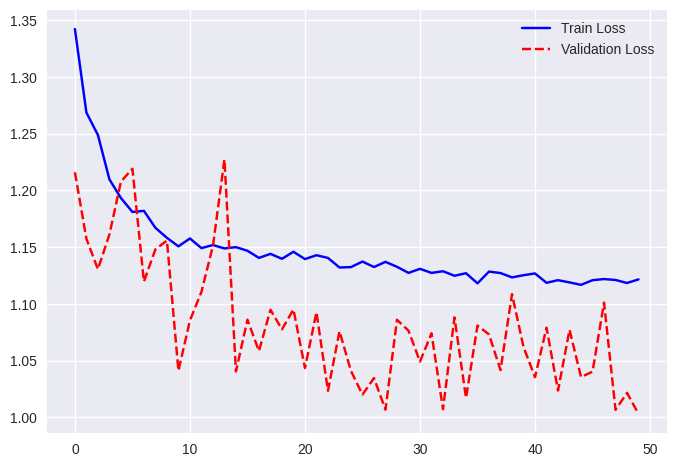

In [14]:
# TODO: Plot training and validation loss over epochs
plt.plot(train_losses, label="Train Loss", color="blue", linestyle="-")
plt.plot(val_losses, label="Validation Loss", color="red", linestyle="--")
plt.legend()
plt.show()

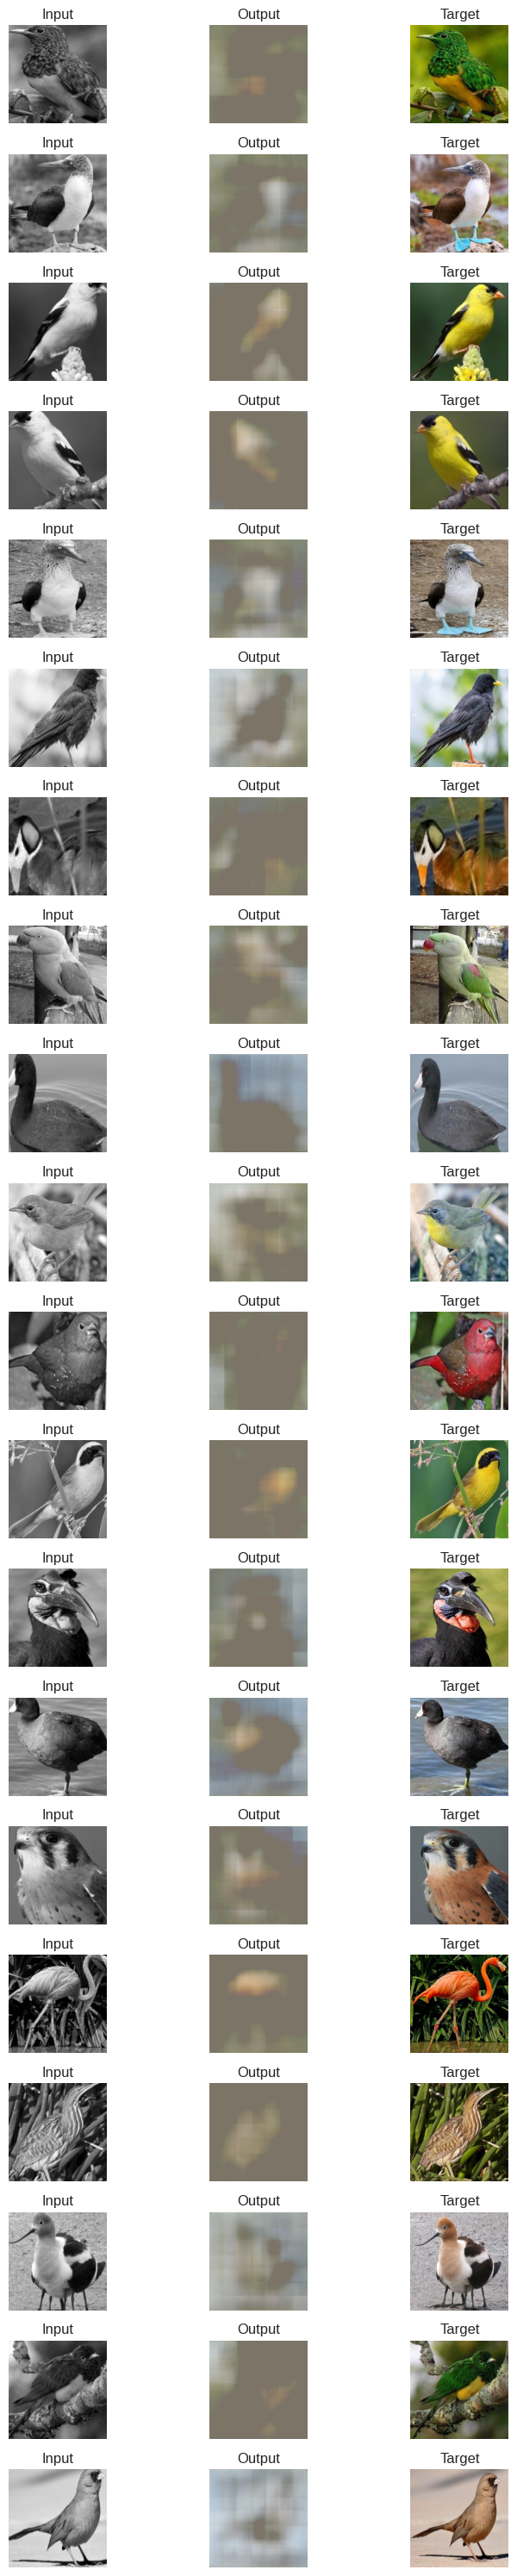

In [15]:
# TODO: Plot grayscale, actual, and predicted inputs
# select some random train images from each 20 classes and plot input, output, and target images
model.eval()
images, targets = next(iter(test_loader))
outputs = model(images.to(device)).detach().cpu()
fig, axes = plt.subplots(20, 3, figsize=(8, 30))
axes = axes.flatten()
for i in range(20):
    input_img = (images[i] * input_std[0]) + input_mean[0]
    axes[3 * i].imshow(input_img.squeeze(), cmap="gray")
    axes[3 * i].axis("off")
    axes[3 * i].set_title("Input")
    
    output_img = outputs[i].permute(1, 2, 0).numpy()
    output_img = (output_img * output_std) + output_mean
    output_img = np.clip(output_img, 0, 1)
    axes[3 * i + 1].imshow(output_img)
    axes[3 * i + 1].axis("off")
    axes[3 * i + 1].set_title("Output")
    
    target_img = targets[i].permute(1, 2, 0).numpy()
    target_img = (target_img * output_std) + output_mean
    target_img = np.clip(target_img, 0, 1)
    axes[3 * i + 2].imshow(target_img)
    axes[3 * i + 2].axis("off")
    axes[3 * i + 2].set_title("Target")
plt.tight_layout()
plt.show()

In [ ]:
# Visualizing the Latent Space
# Latent space visualizations are a powerful tool to understand how the VAE encodes data.
# In this task, students are required to implement a visualization routine to observe the distribution of their data within the latent space.
# The goal is to project high-dimensional encoded data into two dimensions using t-SNE and inspect how different data points are clustered.

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch


# Function to visualize the latent space
def visualize_latent_space(encoder, data_loader, num_samples=1000):
    """
    Uses a 2-dimensional t-SNE plot to visualize latent space of encoded images.

    # TODO: Implement a loop to encode a batch of images and collect their latent representations.
    # TODO: Use t-SNE to reduce dimensions of these latent representations for visualization.

    Parameters:
    encoder (torch.nn.Module): The encoder model component of the VAE.
    data_loader (torch.utils.data.DataLoader)
    num_samples (int): Number of samples to visualize
    """
    # - Set model to evaluation mode

    # - Limit the number of samples based on the user's preference

    # - Move images to the same device as model

    # TODO: Use the encoder to get the mean (mu) of the latent distribution

    # - Stack all obtained latent vectors

    # - t-SNE reduction to 2D for visualization

    # - Plotting the 2D projection


# TODO: Use visualize_latent_space function post-training to observe the latent space


How the distribution of points in the latent space reflects the VAE's capability to generalize grayscale images into colored outputs.

1. **Clustering and Class Representation**:
    - Can you identify clusters in the latent space that correspond to specific image features or categories?
    - How do these clusters inform us about the VAE's ability to differentiate between various input characteristics related to color information?

2. **Continuity and Transitions**:
    - Analyze whether neighboring points in the latent space result in similar or different color outputs. What does this continuity suggest about the latent representation's smoothness?
    - How could these visual transitions impact the quality and realism of the generated colorations, especially for input images that exhibit gradual changes (e.g., transitions in lighting or shading)?

3. **Effectiveness of Dimensionality Reduction**:
    - Assess the effectiveness of t-SNE in projecting high-dimensional latent vectors into a comprehensible 2D representation. What limitations might exist, and how do they affect your interpretation?


Elaborate on how the encoder-decoder architecture facilitates the learning of complex data distributions in image colorization. How does this architecture differ from a simple autoencoder?

Analyze the role of perceptual loss in enhancing the quality of colorized images. How does perceptual loss measure image similarity compared to pixel-wise losses like Mean Squared Error (MSE)?

Discuss how the latent space in a VAE impacts the fidelity and diversity of generated color images. What effects could varying the dimensionality of the latent space have?

# Image Segmentation with U-Net
Image segmentation is a crucial task in computer vision aimed at dividing an image into meaningful segments or objects. The U-Net architecture, famed for its utility in medical imaging, excels at this by leveraging its encoder-decoder structure, which efficiently learns and reconstructs image details. In this task, the U-Net is trained on pairs of images and masks, enabling it to delineate object boundaries at the pixel level with high precision. The training process involves preprocessing the data, adjusting network parameters, and evaluating the model using metrics like Intersection over Union (IoU) to ensure effective segmentation. Successful implementation of U-Net for this purpose can revolutionize applications in areas like autonomous vehicles, medical diagnosis, and agricultural monitoring.

Dataset: https://drive.google.com/drive/folders/1g97fGNQ6buixT8Hp96QyEYOMNKby5Oe8?usp=sharing

## Importing necessary libraries

In [ ]:
# import system libs
import os
import time
import glob
import shutil

# import data handling tools
import cv2
import PIL
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
import matplotlib.pyplot as plt

# import necessary PyTorch libraries
...
print("modules loaded")

## Load the Dataset

In [ ]:
def create_data(data_dir):
    """
    TODO: Traverse through the given data directory to extract and return paths to images and masks.
    - Identify relevant folders for images and masks.
    - Collect file paths from these folders and return them as lists.
    """
    pass


def load_image(image, SIZE):
    """
    TODO: Load and resize an individual image to the specified size, scaling pixel values appropriately.
    - Convert image to array and normalize pixel values.
    - Use resizing techniques to ensure uniform image dimensions.
    """
    pass


def load_images(image_paths, SIZE, mask=False, trim=None):
    """
    TODO: Batch process a list of image paths, loading and organizing images into a numpy array.
    - Handle both image and mask files optionally, managing different channel dimensions.
    - Optionally trim the list of images to handle a subset of data.
    """
    pass


def show_image(image, title=None, cmap=None, alpha=1):
    """
    TODO: Display a single image using matplotlib with options for color map and transparency.
    - Ensure axes are turned off for a cleaner display.
    - Include optional title for context.
    """
    pass


def show_mask(image, mask, cmap=None, alpha=0.4):
    """
    TODO: Overlay a mask on an image to visualize segmentation results.
    - Use transparency to allow both mask and image to be visible.
    - Include color mapping to differentiate mask areas.
    """
    pass


def show_images(imgs, msks):
    """
    TODO: Display multiple image-mask pairs to examine the dataset distribution.
    - Randomly select sample pairs of images and masks for visualization.
    - Use subplots to arrange visuals neatly and use tight layout for optimization.
    """
    pass


SIZE = 256

# TODO: Load and visualize images

## The Architecture
In addition to U-Net, we are going to utilize Attention Gates.
You probably need to read this paper: https://arxiv.org/pdf/1804.03999v3

In [ ]:
# Enhancing U-Net with Dice and Jaccard Losses for Segmentation


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        """
        Compute the Dice coefficient loss.
        - pred: predicted segmentation probabilities
        - target: ground truth masks
        """
        pass


class JaccardLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(JaccardLoss, self).__init__()

    def forward(self, pred, target):
        """
        Compute the Jaccard (IoU) loss.
        - pred: predicted segmentation probabilities
        - target: ground truth masks
        """
        pass


class EncoderBlock(nn.Module):
    def __init__(self, filters, rate, pooling=True):
        super(EncoderBlock, self).__init__()
        # TODO: Initialize Conv2D, Dropout, and optionally MaxPool2D based on the pooling flag.
        pass

    def forward(self, X):
        pass


class DecoderBlock(nn.Module):
    def __init__(self, filters, rate):
        super(DecoderBlock, self).__init__()
        # TODO: Initialize the upsampling layer and encoder block without pooling.
        pass

    def forward(self, X):
        pass


class AttentionGate(nn.Module):
    def __init__(self, filters, bn):
        super(AttentionGate, self).__init__()
        # TODO: Initialize convolutional layers and batch normalization.
        pass

    def forward(self, X):
        # TODO: Implement attention mechanism with element-wise operations.
        pass


class UNetModel(nn.Module):
    def __init__(self):
        super(UNetModel, self).__init__()
        # TODO: Define encoder, decoder blocks, and output layer.
        pass

    def forward(self, x):
        pass

    def compute_loss(self, pred, target):
        """
        Calculate the combined segmentation loss using Dice and Jaccard losses.
        - pred: predicted probability maps
        - target: ground truth probability maps
        """
        pass


# Model instantiation

## Training

In [ ]:
# TODOL:
# set batch size for training
# number of all epochs in training
# number of epochs to run before asking if you want to halt training


# Training


In [ ]:
# TODO: Plot training and validation losses and accuracies

## Plottings

In [ ]:
# Plot the original mask, the one you predicted, and the final one using a threshold

1. **Comparison with Conventional Loss Functions**:
    - How do Dice and Jaccard Losses differ from Cross-Entropy or Mean Squared Error, particularly in terms of sensitivity to class imbalances?
    - What advantages do these losses offer in capturing the spatial overlap between the predicted and true segmentations?

2. **Interpretation of Loss Values**:
    - Discuss what high or low loss scores reveal about the state and effectiveness of your segmentation model.

Evaluate the role of the attention mechanism in optimizing segmentation accuracy in cluttered environments. How does it refine the segmentation process?

What is the importance of skip connections in U-Net, and how do they enhance the accuracy of segmentation tasks?

Explain the difference between the predicted and processed mask above.